# 📌 Overview

This notebook implements the methods described in the paper **"P300-based Character Recognition using CNN and SVM"** by **Sourav Kundu** and **Samit Ari**.

---

# 📌 Dataset

You can download the dataset from the following link:  
[BCI Competition III - Dataset II](https://www.bbci.de/competition/download/competition_iii/albany/BCI_Comp_III_Wads_2004.zip)

---

## 📊 Data Collection

- **Subjects**: Two participants, five sessions each.
- **Task**: Focus on one out of 36 different characters displayed on the screen.

### Matrix Display:
- **Blank Matrix**: 2.5 seconds.
- **Intensifications**: Rows and columns are randomly intensified at 100ms intervals, followed by a 75ms blank period.
- **Repetition**: The process is repeated 15 times per character, totaling 180 intensifications per epoch.

### Data Details:
- **Bandpass Filtered**: 0.1-60Hz
- **Digitized at**: **240Hz** (sampled 240 times per second).
- **Recorded with**: **64 EEG channels**.
- **Data Files**: Four MATLAB *.mat files – one training (85 characters) and one test (100 characters) for each of the two subjects (A and B).

---

## 📌 Contents of the .mat File

For each sample in the Signal matrix, associated events are coded using the following variables:

- **Flashing**:  
  - `1` when row/column was intensified, `0` otherwise.
  
- **StimulusCode**:  
  - `0` when no row/column is being intensified (i.e., matrix is blank).  
  - `1…6` for intensified columns (1 being the left-most column).  
  - `7…12` for intensified rows (7 being the upper-most row).  

- **StimulusType**:  
  - `0` when no row/column is being intensified or the intensified row/column does not contain the desired character.  
  - `1` when the intensified row/column contains the desired character.  
  - This variable allows easy access to labels in the training sets, separating responses that contained the desired character from those that did not. It can also be determined using the **StimulusCode** along with the **TargetChar** that the user focused on.

- **TargetChar**:  
  - The correct character label for each character epoch in the training data.


### 📌Load necessary libraries

In [1]:
from glob import glob
from pathlib import Path
import os
import mne
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

### 📌Dataset

In [2]:
DATA_DIR = Path('D:\work\Projects\p300 speller\data')
DATA_PATHS = glob(str(DATA_DIR / 'BCI_Comp_III_Wads_2004' / '*.mat'))
ELOC_PATH = DATA_DIR / 'BCI_Comp_III_Wads_2004' / 'eloc64.txt'

In [3]:
Subject_A_Test = scipy.io.loadmat(DATA_PATHS[0])
Subject_A_Train = scipy.io.loadmat(DATA_PATHS[1])
Subject_B_Test = scipy.io.loadmat(DATA_PATHS[2])
Subject_B_Train = scipy.io.loadmat(DATA_PATHS[3])

In [4]:
print(Subject_A_Train.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])


In [5]:
print('Header: ', Subject_A_Train['__header__']), print('\nVersion: ', Subject_A_Train['__version__']);

Header:  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Nov 29 08:14:54 2004'

Version:  1.0


In [6]:
Signal_A = Subject_A_Train['Signal']
Signal_B = Subject_B_Train['Signal']
Signal_A.shape

(85, 7794, 64)

In [7]:
# Calculate the time of sampling per character according to the paper
time_of_sampling = 2.5 + (15 * (12 * (100 + 75))) / 100

print(f"Number of samples per character: {Signal_A.shape[1]}")
print("Number of samples per epoch: 160")
print(f"Time of sampling per character according to paper: {time_of_sampling:.2f} seconds")
print("Time of epoch: 6.67 seconds")


Number of samples per character: 7794
Number of samples per epoch: 160
Time of sampling per character according to paper: 317.50 seconds
Time of epoch: 6.67 seconds


In [8]:
# create info
channels = extract_channels(ELOC_PATH)
s_freq = 240

info = mne.create_info(ch_names=channels, sfreq=s_freq, ch_types='eeg')
info

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 120.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 240.0 Hz
>

### 📌Preprocess
8-order Chebysher Type I bandpass filter of cutt-off frequency 0.1-10Hz.

In [9]:
# What's the hell is that?!
# from scipy.signal import cheby1, filtfilt

### 📌plot Signal

Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 7921 samples (33.004 s)

Using matplotlib as 2D backend.


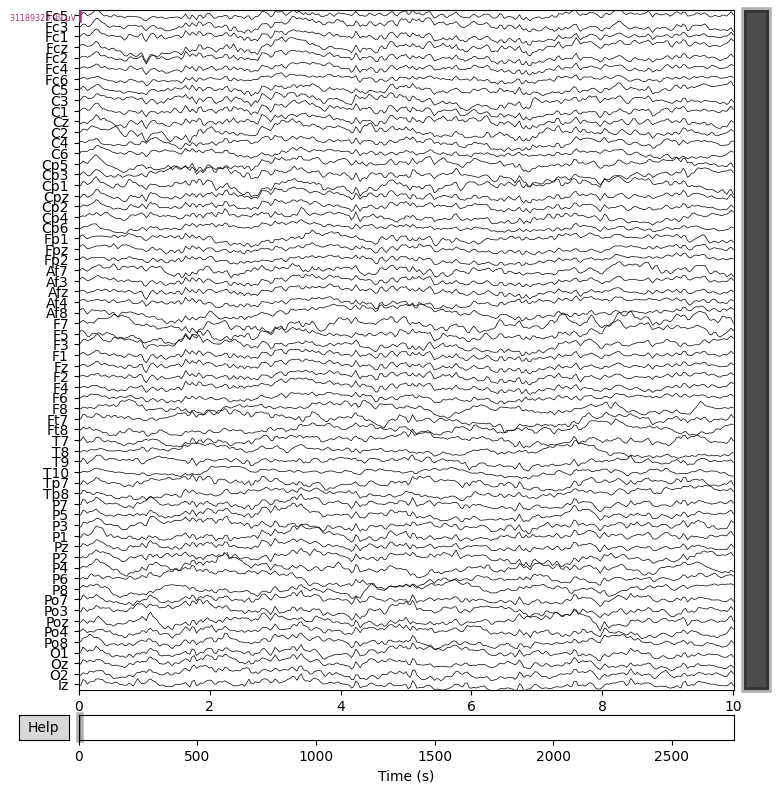

In [11]:
raw_signal_A = mne.io.RawArray(prepare_raw_signal(Signal_A).T, info)
raw_signal_A.filter(l_freq=0.1, h_freq=10)
raw_signal_A.plot(duration=10, n_channels=64, scalings='auto');